<a href="https://colab.research.google.com/github/Surajpatra700/Potato_Leaf_Prediction/blob/main/Potato_Leaf_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [14]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/datasets/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2157 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

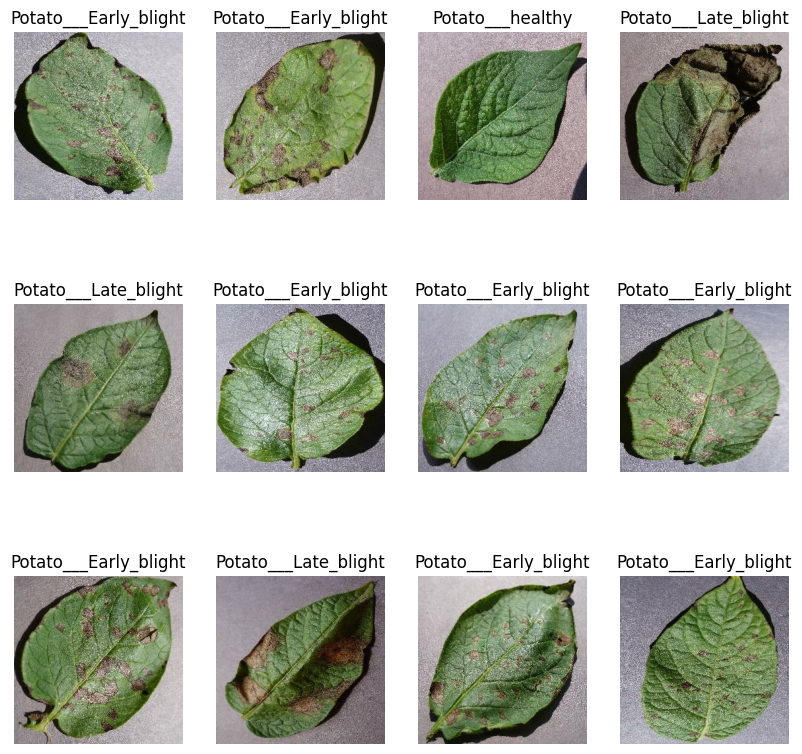

In [21]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
  # print(image_batch.shape)
  # print(label_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])

In [22]:
len(dataset)

68